In [1]:
%matplotlib inline

In [2]:
!pip install ipython
!pip install -q livelossplot==0.3.3
!pip install -q ipython-autotime
%load_ext autotime

time: 413 µs (started: 2022-07-29 10:43:51 +00:00)


In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import csv
import os
import tarfile
from urllib.parse import urlparse
from urllib.request import urlretrieve
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
cudnn.benchmark = True
plt.ion()   # interactive mode

time: 2.56 s (started: 2022-07-29 10:43:51 +00:00)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0
time: 67.7 ms (started: 2022-07-29 10:43:54 +00:00)


In [5]:
labels = pd.read_csv('../input/ddids/file1.csv')
labels['DDI_file'] = '../input/ddids/ddidiversedermatologyimages/'+labels['DDI_file']
labels.to_csv('file_pp.csv')

time: 34.9 ms (started: 2022-07-29 10:43:54 +00:00)


In [6]:
evalpath = './file_pp.csv'

time: 491 µs (started: 2022-07-29 10:43:54 +00:00)


In [7]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    dir = './file_pp.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[2]
            label = line[3:11]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class DDI(Dataset):
    def __init__(self,phase, csv_path,transform=None):
        self.phase = phase
        self.transform = transform
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('DDI classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)

time: 1.9 ms (started: 2022-07-29 10:43:54 +00:00)


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

val_dataset = DDI(transform=data_transforms['val'],phase='Valid',csv_path=evalpath)
image_datasets ={'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,shuffle=True, num_workers=2)for x in ['val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['val']}

DDI classification phase=Valid number of classes=9  number of images=656
time: 13 ms (started: 2022-07-29 10:43:54 +00:00)


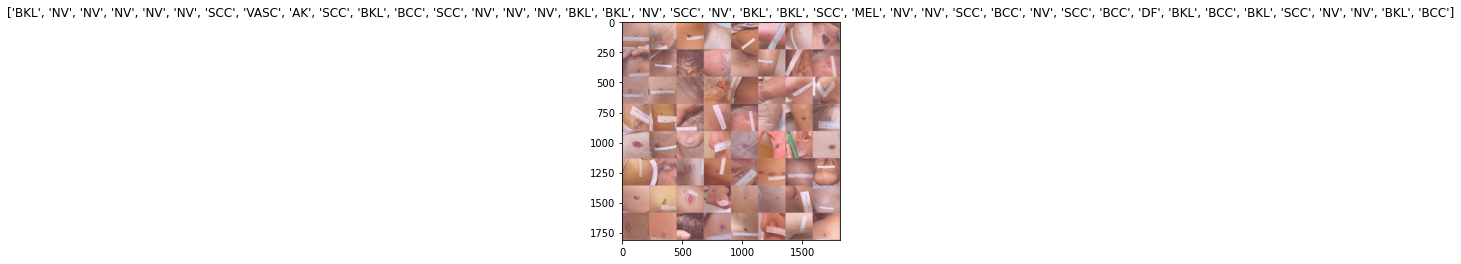

time: 6.84 s (started: 2022-07-29 10:43:54 +00:00)


In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['val']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [10]:
model=models.vit_b_32(pretrained=False)
print(model)
model.heads=nn.Sequential(nn.Linear(768, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isicvit/VIT32B_wt_epoch_19_batch_1250_auc_0.8908.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

time: 13.2 s (started: 2022-07-29 10:44:01 +00:00)


In [11]:
def validate():
    model.eval()
    
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        #labels = labels.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()#.cpu().numpy()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images
             
    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)

    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)
            
    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    print('\n')
    print(auc_lst)
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print(auc)
    print(acc)
    f1s=0.0
    model.train()
    return auc,acc,f1s

time: 1.8 ms (started: 2022-07-29 10:44:14 +00:00)


In [12]:
validate()



[0.53573303 0.53701704 0.53034259 0.22047546 0.53257713 0.42572412
 0.32574103 0.52285741]


[0.54115854 0.6554878  0.91463415 0.99390244 0.875      0.96646341
 0.97560976 0.91920732]
0.45380847677016417
0.8551829268292683


(0.45380847677016417, 0.8551829268292683, 0.0)

time: 17.3 s (started: 2022-07-29 10:44:14 +00:00)
